In [ ]:
 %cd /content/
!rm -rf outflow-tracking/
!git clone https://github.com/dkarkada/outflow-tracking
%cd outflow-tracking



/content
Cloning into 'outflow-tracking'...
remote: Enumerating objects: 359, done.
remote: Counting objects: 100% (76/76), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 359 (delta 49), reused 71 (delta 45), pack-reused 283
Receiving objects: 100% (359/359), 177.96 MiB | 20.76 MiB/s, done.
Resolving deltas: 100% (99/99), done.
Checking out files: 100% (136/136), done.
/content/outflow-tracking


In [ ]:
import matplotlib.pyplot as plt
import matplotlib._color_data as mcd
import matplotlib.colors as mplc

plt.rc('figure', dpi=100)

import numpy as np
from scipy.special import softmax
import pickle

from IPython.display import display
import pandas as pd

import cv2
import imageio

In [ ]:
# with open("times.txt") as f:
#     lines = f.readlines()
#     lines = [float(l.split()[1]) for l in lines][::3]
#     times = np.round(lines, 6)*1000000

# imgs = []
# for frame_num in range(20):
#     im = np.load('sim_data/z_tracer_{}.npy'.format(50+10*frame_num))
#     im = cv2.resize(im, (500, 500))
#     im = cv2.GaussianBlur(im, (3, 3), cv2.BORDER_CONSTANT)

#     # im[im < 1e-5] = 1e-5
#     # im = np.log10(im / 1e-5)

#     im[im < 0] = 0
#     im[im > 0.06] = 0.06
#     im = cv2.normalize(im, None, 255, 0, cv2.NORM_MINMAX, cv2.CV_8UC1)
    
#     time_str = 't = {} years'.format(int(times[frame_num]))
#     im = cv2.applyColorMap(im, cv2.COLORMAP_PINK)
#     im = cv2.putText(im, time_str, org=(10,30),
#                      fontFace=cv2.FONT_HERSHEY_TRIPLEX, fontScale=.8,
#                      color=(191, 165, 232), lineType=cv2.LINE_AA
#                     )
#     imgs.append(im)

# imageio.mimsave('outflows.gif', imgs, fps = 5)

In [ ]:
class Dendrogram:

    def make_recurse(self, start, top, visited):

        within = lambda r, c: (0 <= r < im.shape[0]) and (0 <= c < im.shape[1])

        def neighbors(r, c):
            return [(r-1, c), (r+1, c), (r, c-1), (r, c+1),
                    (r-1, c-1), (r-1, c+1), (r+1, c-1), (r+1, c+1)]
        
        def find_min(start):
            im = self.img
            visited = np.zeros(im.shape)
            cur = im[start]
            min_ind = start
            bfs_queue = {start}
            while bfs_queue:
                r, c = bfs_queue.pop()
                if not within(r, c) or visited[r, c]:
                    continue
                visited[r, c] = 1
                if im[r, c] < cur:
                    cur = im[r, c]
                    min_ind = (r, c)
                    bfs_queue = {*neighbors(r, c)}
                if im[r, c] == cur:
                    for n in neighbors(r, c):
                        if within(*n) and not visited[n]:
                            bfs_queue.add(n)
            return min_ind, cur
        
        im = self.img
        (r, c), bottom = find_min(start)
        level = bottom
        d = Branch(self)
        
        map = d.map
        bfs_queue = {(r, c)}
        while level < top:
            failed = set()
            siblings = []
            while bfs_queue:
                r, c = bfs_queue.pop()
                if not within(r, c) or visited[r, c]:
                    continue
                if im[r, c] == level:
                    visited[r, c] = 1
                    map[r, c] = 1
                    for n in neighbors(r, c):
                        if within(*n) and not visited[n]:
                            bfs_queue.add(n)
                elif im[r, c] < level:
                    sibling, surround = self.make_recurse((r, c),
                                                          level, visited)
                    bfs_queue = bfs_queue.union(surround)
                    siblings.append(sibling)
                else:
                    failed.add((r, c))
            
            if siblings:
                next_d = Branch(self)
                siblings.append(d)
                for s in siblings:
                    s.parent = next_d
                    next_d.children.append(s)
                    next_d.map[s.map>0] = 1
                map[map>0] = level - np.maximum(im[map>0], bottom)
                d = next_d
                map = d.map
                bottom = level
            
            level += 1
            bfs_queue = failed
        
        root_correction = 1 if top==256 else 0
        map[map>0] = top - np.maximum(im[map>0], bottom) - root_correction
        return d, bfs_queue
    
    def __init__(self, img):
        img = img - img.min()
        if img.max() != 0:
            img = img / img.max()
        img = np.round(img * 255)
        self.img = img
        
        h, w = self.img.shape
        coords = np.meshgrid(np.linspace(-w/2, w/2, w, endpoint=False),
                 
                             np.linspace(h/2, -h/2, h, endpoint=False))
        self.coords = np.stack(coords)

        visited = np.zeros(img.shape)
        ind = np.unravel_index(np.argmax(img), img.shape)
        root, _ = self.make_recurse(ind, 256, visited)
        self.root = root

        root.merge()
        root.calculate()
        self.branches = root.descendants
        self.N = len(self.branches)
        for n, b in enumerate(self.branches):
            b.id = n
        
        self.metric = np.zeros((self.N, self.N))
        self.compute_metric(root)
        
        self.hierarchy = np.zeros((self.N, self.N))
        for branch_id in range(self.N):
            twigs = self.branches[branch_id].descendants
            for twig_id in [t.id for t in twigs]:
                self.hierarchy[branch_id, twig_id] = 1
        
        mass_arr = [b.mass for b in self.branches]
        # append source mass
        self.masses = np.array(mass_arr + [max(mass_arr)])
        self.x = np.array([b.x for b in self.branches])
        
    def compute_metric(self, branch):
        if len(branch.children) == 0:
            return
        
        subtrees = []
        for c in branch.children:
            self.compute_metric(c)
            subtree = c.descendants
            for b in subtree:
                dist = 1 + self.metric[c.id, b.id]
                assert self.metric[branch.id, b.id] == 0
                self.metric[branch.id, b.id] = dist
                self.metric[b.id, branch.id] = dist
            subtrees.append((c, subtree))
            
        for c1_ind in range(len(subtrees)):
            for c2_ind in range(c1_ind+1, len(subtrees)):
                c1, subtree1 = subtrees[c1_ind]
                c2, subtree2 = subtrees[c2_ind]
                for b1 in subtree1:
                    for b2 in subtree2:
                        dist = 2 + self.metric[c1.id, b1.id] + self.metric[c2.id, b2.id]
                        assert self.metric[b1.id, b2.id] == 0
                        self.metric[b1.id, b2.id] = dist
                        self.metric[b2.id, b1.id] = dist

    def print(self):
        dfs_stack = [(self.root, 0)]
        while len(dfs_stack) > 0:
            b, level = dfs_stack.pop()
            print("{}{}".format(level*"  ", b.id))
            for c in b.children:
                dfs_stack.append((c, level+1))
            

class Branch:
    
    def __init__(self, dendrogram):
        self.dendrogram = dendrogram
        self.map = np.zeros(dendrogram.img.shape)

        self.children = []
        self.descendants = [self]
        self.parent = None
        
        self.mass = None
        self.total_mass = None
        self.mass_frac = None
        self.x = None        
        self.covariance = None
        
        self.id = None
    
    def merge(self, depth_thresh=8):
        def do_merge(c):
            self.map += c.map
            new_children = [grandchild for grandchild in c.children]
            for new_child in new_children:
                new_child.parent = self
            return new_children

        new_children = []
        for c in self.children:
            c.merge(depth_thresh)                
            if np.max(c.map) < depth_thresh:
                new_children += do_merge(c)
            else:
                new_children.append(c)
        self.children = new_children
        
        if len(self.children) == 1:
            c = self.children.pop()
            self.children = do_merge(c)
        
        for c in self.children:
            self.descendants += c.descendants
            
    def calculate(self):        
        for c in self.children:
            c.calculate()
            
        self.mass = self.map.sum()
        # COMPLETE HACK
        self.mass = max(1, self.mass)
        self.total_mass = self.mass + sum([c.mass for c in self.children])
        self.mass_frac = self.mass / self.total_mass
        # center of mass of exclusive mass
        x_vec = np.einsum('ijk,jk->i', self.dendrogram.coords, self.map)
        self.x = x_vec / self.mass
        
        # covariance matrix calculation
        dx_coords = self.dendrogram.coords - self.x[:, None, None]
        outers = np.einsum('ijk,ljk->iljk', dx_coords, dx_coords)
        cov_mat = np.einsum('iljk,jk->il', outers, self.map)
        self.covariance = cov_mat / self.mass

In [ ]:
def plot_gaussian_estimate(dendro):
    def get_ellipse(cov):
        a, b, c = cov[0,0], cov[0,1], cov[1,1]
        c1 = (a+c)/2
        c2 = np.linalg.norm([b, (a-c)/2])
        l1 = c1 + c2
        l2 = c1 - c2
        assert l1 >= 0
        assert l2 >= 0
        theta = 0
        if b == 0 and a < c:
            theta = np.pi/2
        if b != 0:
            theta = np.arctan2(l1-a, b)
        t = np.linspace(0, 2*np.pi, 30)
        x = np.sqrt(6*l1)*np.cos(-theta)*np.cos(t) - np.sqrt(6*l2)*np.sin(-theta)*np.sin(t)
        y = np.sqrt(6*l1)*np.sin(-theta)*np.cos(t) + np.sqrt(6*l2)*np.cos(-theta)*np.sin(t)
        return x, y

    plt.imshow(dendro.img, cmap=plt.cm.Greys_r)
    plt.colorbar()
    for b in dendro.branches:
        x, y = get_ellipse(b.covariance)
        mu_x = b.x[0] + b.map.shape[1]//2
        mu_y = b.map.shape[0]//2 - b.x[1]
        x, y = x + mu_x, y + mu_y
        plt.plot(x, y, color=(.7,.3,.3,b.mass_frac**3))
    plt.show()

In [ ]:
with open('params_final.pickle', 'rb') as handle:
    link_mats = pickle.load(handle)
link_mats = [softmax(mat, axis=1) for mat in link_mats]

dendro_frames = []
for frame_num in range(20): 
    with open('dendros/{:02d}.pickle'.format(frame_num), 'rb') as handle:
        dendro_frames.append(pickle.load(handle)) 

In [ ]:
np.set_printoptions(suppress=True)
np.set_printoptions(edgeitems=30, linewidth=100000)

def print_linking_matrix(mat, d, d_next):
    print(d.masses[:-1])
    print(d_next.masses[:-1])

    mass_mat = np.einsum('ij,i->ij', mat, d.masses)
    df = pd.DataFrame(mass_mat.round().astype(int),
                      index=list(range(d.N))+['src'],
                      columns=list(range(d_next.N))+['sink'])
    display(df)
    for b in d.branches:
        if b.mass_frac <= 0.8:
            df = df.drop(b.id, axis=0)
    for b in d_next.branches:
        if b.mass_frac <= 0.8:
            df = df.drop(b.id, axis=1)
    display(df)

[36169.  1129.    54.]
[62022.   267.  2346.  2298.   120.   132.   149.]


,0,1,2,3,4,5,6,sink
0,34112,191,1745,80,0,2,40,0
1,0,0,15,954,23,82,55,0
2,0,0,0,0,54,0,0,0
src,0,0,2,0,0,0,0,36167


,0,1,3,4,5,6,sink
0,34112,191,80,0,2,40,0
1,0,0,954,23,82,55,0
2,0,0,0,54,0,0,0
src,0,0,0,0,0,0,36167


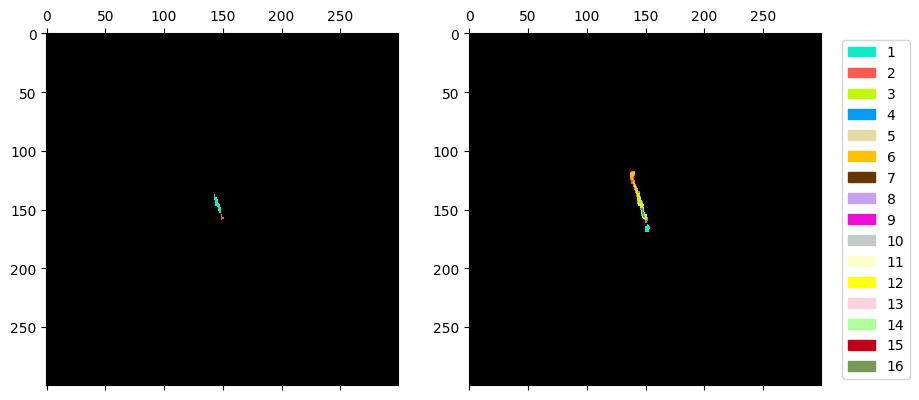

[62022.   267.  2346.  2298.   120.   132.   149.]
[91693.   406.  5139.  2480.   388.   830.    24.    12.   136.    78.]


,0,1,2,3,4,5,6,7,8,9,sink
0,60776,291,954,0,0,0,0,0,1,0,0
1,0,0,5,0,262,0,0,0,0,0,0
2,0,14,2274,0,0,0,0,0,0,58,0
3,0,0,0,2003,0,295,0,0,0,0,0
4,0,0,0,0,0,100,20,0,0,0,0
5,0,0,0,0,0,119,0,10,0,3,0
6,0,0,36,0,0,0,0,0,113,0,0
src,0,0,0,0,0,0,0,0,0,0,62022


,0,1,4,5,6,7,8,9,sink
0,60776,291,0,0,0,0,1,0,0
1,0,0,262,0,0,0,0,0,0
3,0,0,0,295,0,0,0,0,0
4,0,0,0,100,20,0,0,0,0
5,0,0,0,119,0,10,0,3,0
6,0,0,0,0,0,0,113,0,0
src,0,0,0,0,0,0,0,0,62022


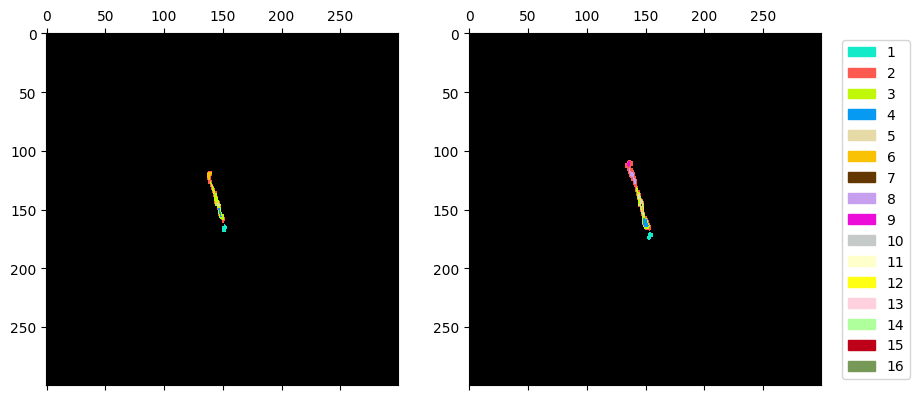

[91693.   406.  5139.  2480.   388.   830.    24.    12.   136.    78.]
[121710.    260.   3515.    655.    411.    204.    436.     24.   1178.   2367.    372.    769.]


,0,1,2,3,4,5,6,7,8,9,10,11,sink
0,89554,0,0,0,7,134,9,0,29,1482,1,475,0
1,0,406,0,0,0,0,0,0,0,0,0,0,0
2,5060,0,0,0,0,0,0,0,0,26,51,2,0
3,0,0,2120,360,0,0,0,0,0,0,0,0,0
4,0,0,0,0,388,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,286,0,543,0,0,0,0
6,0,0,0,0,0,0,0,24,0,0,0,0,0
7,0,0,0,0,0,0,0,0,12,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,136,0,0
9,0,0,78,0,0,0,0,0,0,0,0,0,0


,0,1,4,5,7,8,10,11,sink
0,89554,0,7,134,0,29,1,475,0
1,0,406,0,0,0,0,0,0,0
4,0,0,388,0,0,0,0,0,0
5,0,0,0,0,0,543,0,0,0
6,0,0,0,0,24,0,0,0,0
7,0,0,0,0,0,12,0,0,0
8,0,0,0,0,0,0,136,0,0
9,0,0,0,0,0,0,0,0,0
src,0,0,0,0,0,0,0,0,91693


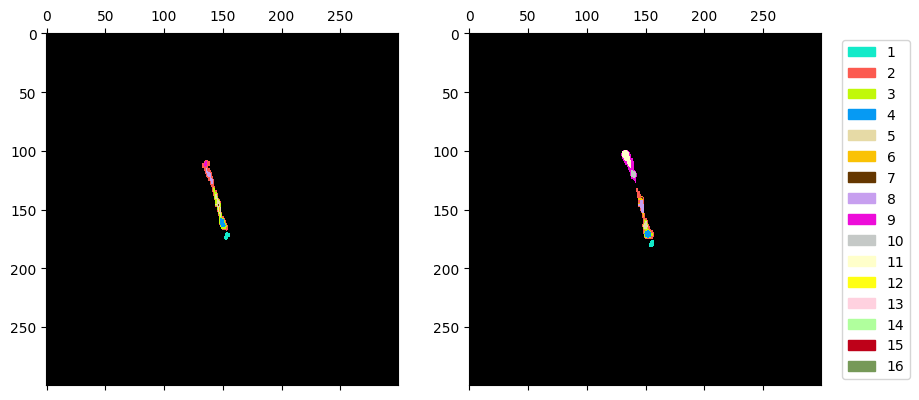

[121710.    260.   3515.    655.    411.    204.    436.     24.   1178.   2367.    372.    769.]
[144978.   8286.   3049.   1148.     65.   2754.   2421.    307.   3539.    212.    716.]


,0,1,2,3,4,5,6,7,8,9,10,sink
0,120680,1023,0,0,0,0,0,0,0,0,7,0
1,0,0,260,0,0,0,0,0,0,0,0,0
2,0,3233,0,282,0,0,0,0,0,0,0,0
3,0,0,653,0,0,0,0,0,0,0,2,0
4,0,0,410,0,0,0,0,0,0,0,1,0
5,0,0,204,0,0,0,0,0,0,0,0,0
6,0,0,0,387,49,0,0,0,0,0,0,0
7,0,0,0,0,0,24,0,0,0,0,0,0
8,0,0,0,0,0,1178,0,0,0,0,0,0
9,0,0,0,0,0,0,928,150,1289,0,0,0


,0,2,4,5,7,9,10,sink
0,120680,0,0,0,0,0,7,0
1,0,260,0,0,0,0,0,0
4,0,410,0,0,0,0,1,0
5,0,204,0,0,0,0,0,0
7,0,0,0,24,0,0,0,0
8,0,0,0,1178,0,0,0,0
10,0,0,0,0,0,0,372,0
11,0,0,0,0,0,769,0,0
src,0,0,0,0,0,0,0,121710


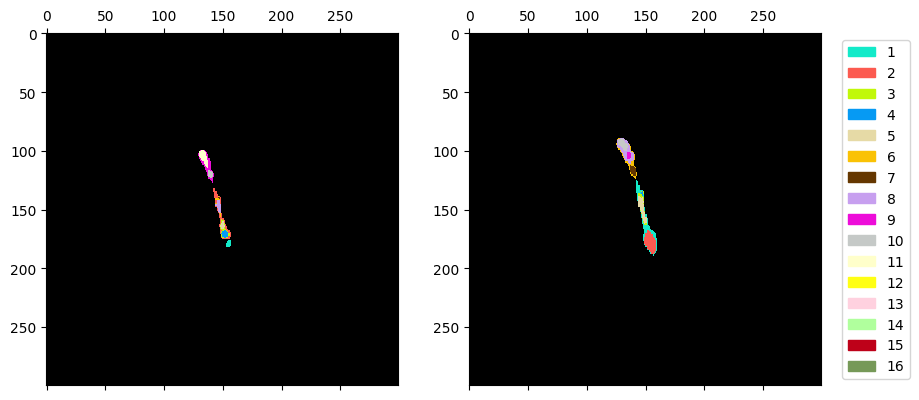

[144978.   8286.   3049.   1148.     65.   2754.   2421.    307.   3539.    212.    716.]
[173743.   9154.   5382.   3367.   3387.    180.    789.     91.    105.   5905.    138.   3638.]


,0,1,2,3,4,5,6,7,8,9,10,11,sink
0,143919,1055,0,0,0,0,4,0,0,0,0,0,0
1,0,7603,0,683,0,0,0,0,0,0,0,0,0
2,0,0,3049,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1079,0,0,0,0,69,0,0,0,0
4,0,0,0,0,0,0,0,65,0,0,0,0,0
5,0,0,0,0,2136,129,490,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,2421,0,0,0
7,0,0,0,0,0,0,0,0,0,189,118,0,0
8,0,0,0,0,0,0,0,0,0,115,0,3424,0
9,0,0,0,0,0,0,0,0,0,212,0,0,0


,0,2,5,6,7,8,10,11,sink
0,143919,0,0,4,0,0,0,0,0
2,0,3049,0,0,0,0,0,0,0
4,0,0,0,0,65,0,0,0,0
5,0,0,129,490,0,0,0,0,0
7,0,0,0,0,0,0,118,0,0
9,0,0,0,0,0,0,0,0,0
10,0,0,0,0,0,0,0,0,0
src,0,0,0,0,0,0,0,0,144978


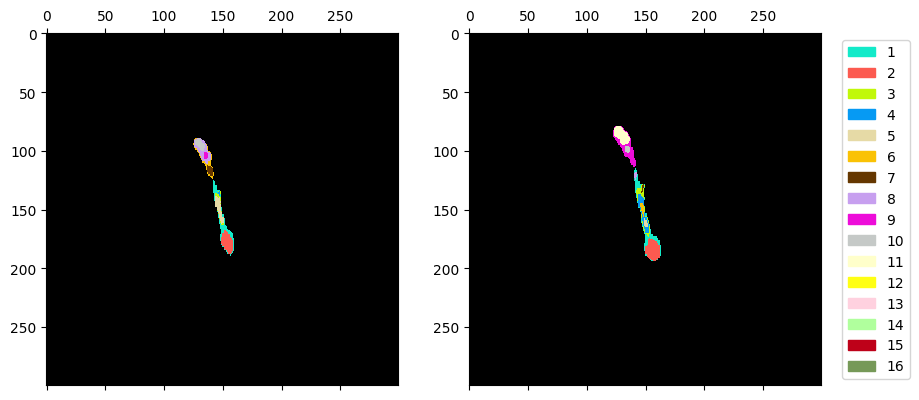

[173743.   9154.   5382.   3367.   3387.    180.    789.     91.    105.   5905.    138.   3638.]
[214239.    252.   6835.   5865.    358.   7746.    418.    504.   1212.    792.   8935.]


,0,1,2,3,4,5,6,7,8,9,10,sink
0,172507,0,1210,0,0,0,0,0,0,0,26,0
1,0,0,9129,0,25,0,0,0,0,0,0,0
2,0,0,0,5382,0,0,0,0,0,0,0,0
3,0,0,0,0,32,3062,0,0,0,273,0,0
4,0,0,0,0,99,2931,242,115,0,0,0,0
5,0,0,0,0,3,0,0,177,0,0,0,0
6,0,0,0,0,23,0,0,0,766,0,0,0
7,0,0,0,0,0,0,0,0,0,91,0,0
8,0,105,0,0,0,0,0,0,0,0,0,0
9,5174,0,0,0,0,0,0,0,0,0,731,0


,0,1,3,4,6,7,8,9,10,sink
0,172507,0,0,0,0,0,0,0,26,0
2,0,0,5382,0,0,0,0,0,0,0
5,0,0,0,3,0,177,0,0,0,0
6,0,0,0,23,0,0,766,0,0,0
7,0,0,0,0,0,0,0,91,0,0
8,0,105,0,0,0,0,0,0,0,0
10,0,34,0,0,0,0,0,0,104,0
11,0,0,0,0,0,0,0,0,3638,0
src,0,0,0,0,0,0,0,0,0,173743


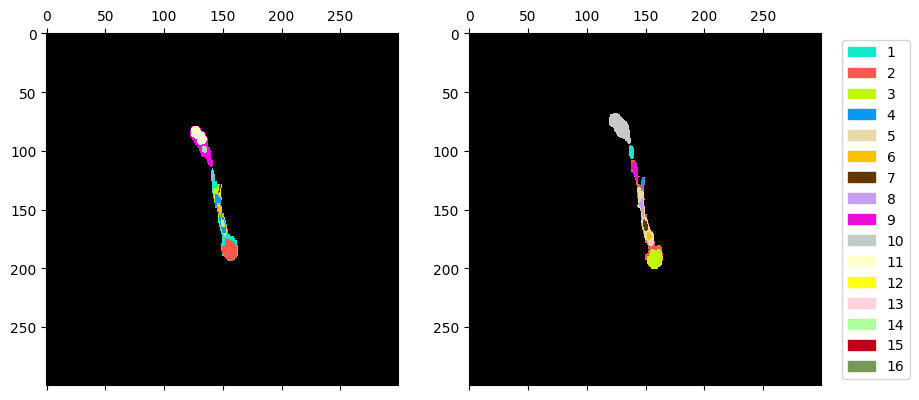

[214239.    252.   6835.   5865.    358.   7746.    418.    504.   1212.    792.   8935.]
[205641.  26195.    281.   5640.   8452.   1826.   2465.     48.   1117.  15452.    837.   7089.]


,0,1,2,3,4,5,6,7,8,9,10,11,sink
0,213702,255,0,0,0,0,0,0,0,248,34,1,0
1,0,0,0,0,0,0,0,0,0,0,0,252,0
2,0,6835,0,0,0,0,0,0,0,0,0,0,0
3,0,2945,0,2920,0,0,0,0,0,0,0,0,0
4,0,0,86,0,0,0,0,0,0,0,272,0,0
5,0,0,0,0,7625,119,0,1,0,0,0,0,0
6,0,0,0,0,0,418,0,0,0,0,0,0,0
7,0,0,0,0,0,504,0,0,0,0,0,0,0
8,0,0,0,0,0,0,607,34,571,0,0,0,0
9,0,0,0,0,173,0,615,0,0,0,4,0,0


,0,2,3,5,7,8,10,11,sink
0,213702,0,0,0,0,0,34,1,0
1,0,0,0,0,0,0,0,252,0
3,0,0,2920,0,0,0,0,0,0
4,0,86,0,0,0,0,272,0,0
6,0,0,0,418,0,0,0,0,0
7,0,0,0,504,0,0,0,0,0
8,0,0,0,0,34,571,0,0,0
9,0,0,0,0,0,0,4,0,0
10,0,5,0,0,0,0,0,2782,0
src,0,0,0,0,0,0,0,0,214239


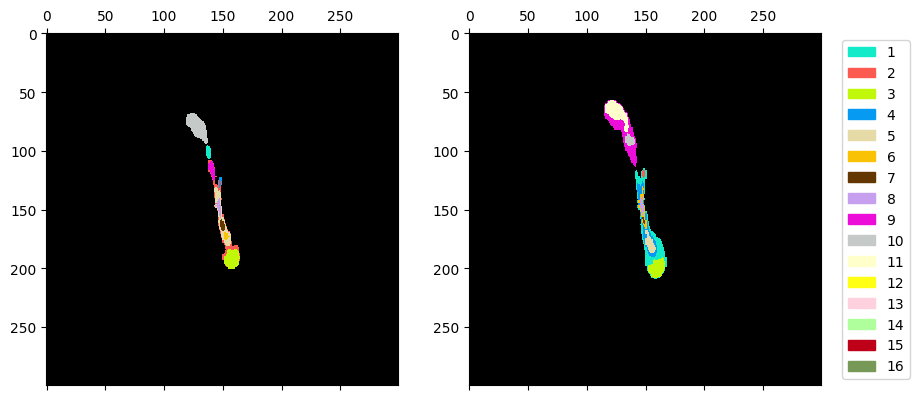

[205641.  26195.    281.   5640.   8452.   1826.   2465.     48.   1117.  15452.    837.   7089.]
[221128.  37075.    238.   7946.   5721.   7237.   2970.   2545.     63.    471.   3675.  24963.    403.   4237.]


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,sink
0,203568,2021,0,0,0,0,0,51,0,0,0,0,1,0,0
1,0,26194,0,0,0,0,0,1,0,0,0,0,0,0,0
2,0,11,270,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,3110,2529,0,0,0,0,0,0,0,0,0,0
4,0,0,0,5642,0,2810,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,435,1391,0,0,0,0,0,0,0,0
6,0,0,0,0,0,339,0,1840,42,244,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,48,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,1117,0,0,0,0
9,0,0,0,0,0,0,0,10,0,0,0,15442,0,0,0


,1,2,4,6,8,9,10,11,12,13,sink
0,2021,0,0,0,0,0,0,0,1,0,0
2,11,270,0,0,0,0,0,0,0,0,0
3,0,0,2529,0,0,0,0,0,0,0,0
5,0,0,0,1391,0,0,0,0,0,0,0
7,0,0,0,0,0,0,48,0,0,0,0
8,0,0,0,0,0,0,1117,0,0,0,0
10,0,0,0,0,0,0,0,0,837,0,0
11,0,0,0,0,0,0,0,318,0,6771,0
src,0,0,0,0,0,0,0,0,0,0,205641


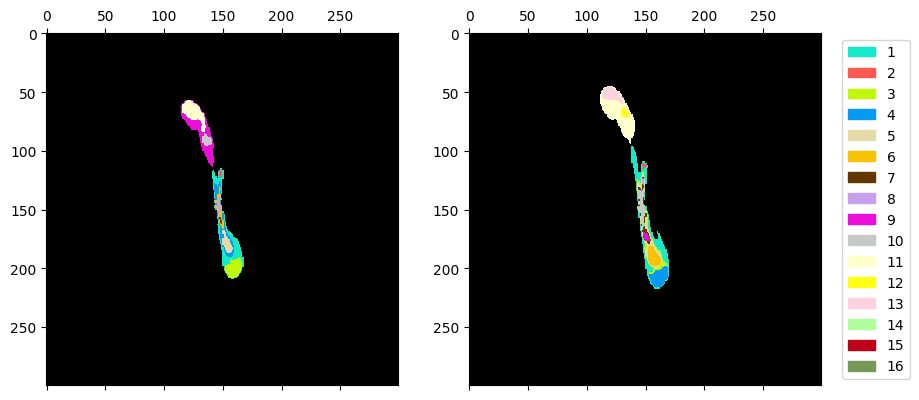

[221128.  37075.    238.   7946.   5721.   7237.   2970.   2545.     63.    471.   3675.  24963.    403.   4237.]
[234570.  16672.  35765.    201.  24401.   3337.   5268.   2401.   3697.    768.   3529.    195.  36215.]


,0,1,2,3,4,5,6,7,8,9,10,11,12,sink
0,217849,3279,0,0,0,0,0,0,0,0,0,0,0,0
1,0,32797,4278,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,238,0,0
3,0,0,7946,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,4021,1700,0,0,0,0,0,0,0,0
5,0,0,0,101,7136,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,1622,1080,268,0,0,0,0,0
7,0,0,0,0,0,0,2545,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,63,0,0,0
9,0,0,0,9,0,0,0,0,0,0,462,0,0,0


,0,3,5,7,9,10,11,12,sink
1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,238,0,0
4,0,0,1700,0,0,0,0,0,0
6,0,0,0,1080,0,0,0,0,0
8,0,0,0,0,0,63,0,0,0
9,0,9,0,0,0,462,0,0,0
10,0,0,0,0,419,1264,0,0,0
11,0,0,0,0,0,0,0,24963,0
12,0,0,0,0,0,0,0,403,0
13,0,0,0,0,0,0,0,4237,0


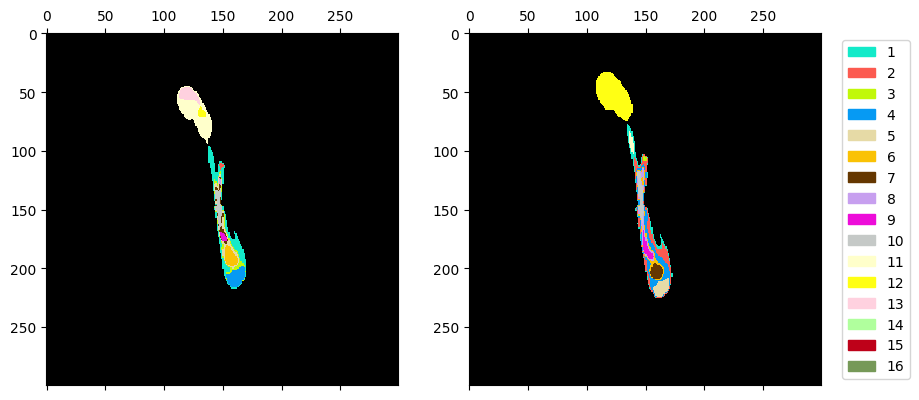

[234570.  16672.  35765.    201.  24401.   3337.   5268.   2401.   3697.    768.   3529.    195.  36215.]
[239505.  78068.     73.  19589.   1452.   2021.   2359.     21.  12347.   1177.    120.   2035.    186.    471.  39992.    204.    626.]


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,sink
0,234570,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,16671,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,0,34065,0,1,4,479,936,0,0,0,0,0,0,0,0,3,276,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,201,0,0,0,0
4,0,21205,0,2286,608,287,15,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,3337,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,64,3,0,5201,0,0,0,0,0,0,0,0,0
7,0,0,48,0,0,0,0,0,2261,0,0,0,0,0,0,92,0,0
8,0,0,0,0,0,0,0,0,795,2901,0,0,0,0,0,0,0,0
9,0,0,0,0,11,0,0,0,0,0,0,757,0,0,0,0,0,0


,2,4,5,6,7,8,10,11,12,13,14,15,16,sink
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,201,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,48,0,0,0,0,2261,0,0,0,0,0,92,0,0
9,0,11,0,0,0,0,0,757,0,0,0,0,0,0
10,0,0,0,0,14,0,81,3314,120,0,0,0,0,0
11,0,0,0,0,0,0,0,0,0,191,0,0,0,0
12,0,0,0,0,0,0,0,0,0,0,36215,0,0,0
src,0,0,0,0,0,0,0,0,0,0,0,0,0,234570


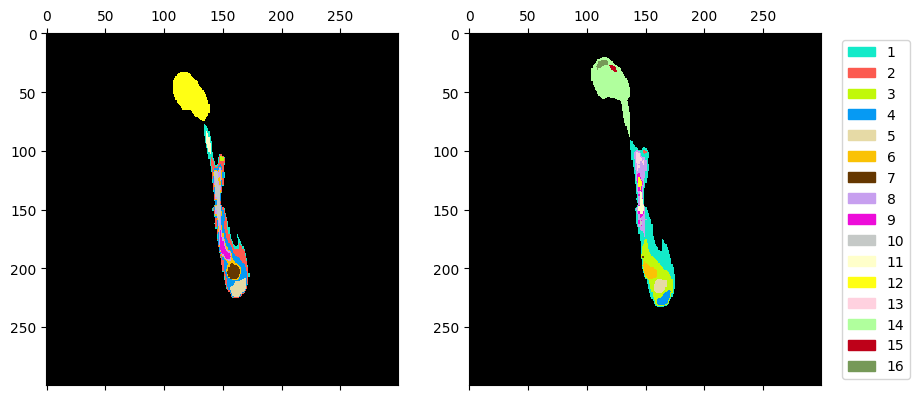

[239505.  78068.     73.  19589.   1452.   2021.   2359.     21.  12347.   1177.    120.   2035.    186.    471.  39992.    204.    626.]
[194896. 115906.   9117.     51.  24100.    208.    757.   1721.   9423.   6634.    403.     36.     22.   4993.   2377.    435.   1050.     89.   1129.  60426.    107.    315.]


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,sink
0,239505,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,78010,0,0,0,58,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,73,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,19589,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1452,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,2021,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,2359,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,21,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,10391,553,0,0,0,0,855,170,337,41,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1177,0,0


,1,3,4,5,6,7,10,11,12,13,15,17,18,19,20,21,sink
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,1452,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,2021,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,2359,0,0,0,0,0,0,0,0,0,0,0,0
7,0,0,0,21,0,0,0,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,170,41,0,0,0,0,0
10,0,0,0,0,0,0,0,0,120,0,0,0,0,0,0,0,0
11,0,22,0,0,0,0,141,18,0,965,0,0,0,0,0,0,0
12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
13,0,0,0,0,0,0,0,0,0,0,0,0,471,0,0,0,0


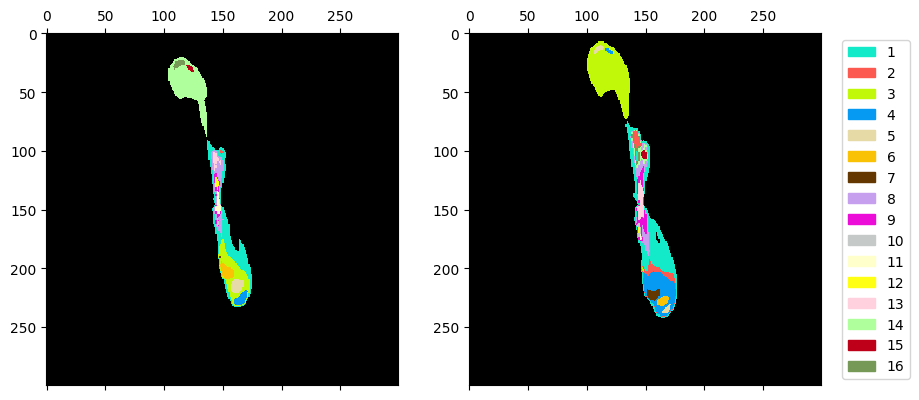

[194896. 115906.   9117.     51.  24100.    208.    757.   1721.   9423.   6634.    403.     36.     22.   4993.   2377.    435.   1050.     89.   1129.  60426.    107.    315.]
[157452. 169451.  40988.   6862.  11178.    600.   8043.   1365.   5344.  73485.]


,0,1,2,3,4,5,6,7,8,9,sink
0,185150,9747,0,0,0,0,0,0,0,0,0
1,0,115126,0,780,0,0,0,0,0,0,0
2,115,0,9002,0,0,0,0,0,0,0,0
3,0,0,51,0,0,0,0,0,0,0,0
4,317,0,23783,0,0,0,0,0,0,0,0
5,3,0,205,0,0,0,0,0,0,0,0
6,10,0,747,0,0,0,0,0,0,0,0
7,0,0,1693,28,0,0,0,0,0,0,0
8,0,0,0,8659,716,0,0,0,48,0,0
9,0,0,0,0,6634,0,0,0,0,0,0


,2,5,6,7,8,9,sink
1,0,0,0,0,0,0,0
3,51,0,0,0,0,0,0
4,23783,0,0,0,0,0,0
5,205,0,0,0,0,0,0
6,747,0,0,0,0,0,0
7,1693,0,0,0,0,0,0
10,0,403,0,0,0,0,0
11,0,36,0,0,0,0,0
12,0,22,0,0,0,0,0
13,0,0,4993,0,0,0,0


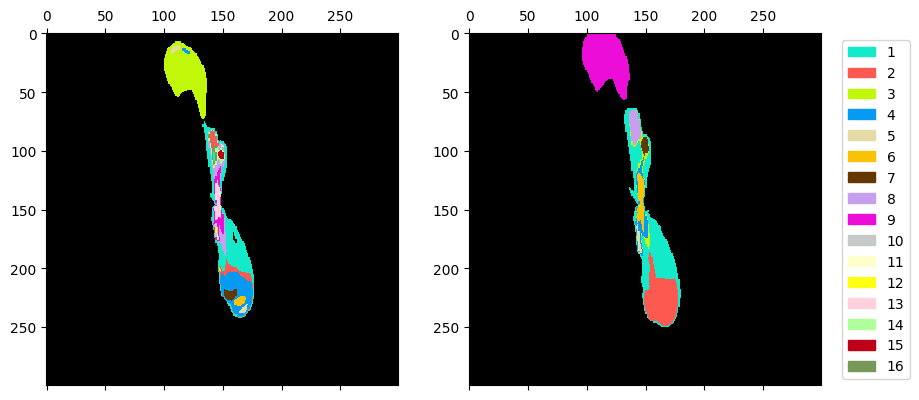

[157452. 169451.  40988.   6862.  11178.    600.   8043.   1365.   5344.  73485.]
[108011.     31. 179836.  65250.  36184.   8750.    480.   3237.    911.     76.  13074.   1174.    345.   2041.  11736.  47845.    128.   1762.]


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,sink
0,28390,0,128859,0,0,0,0,0,0,0,0,0,0,0,108,96,0,0,0
1,0,0,168593,0,0,0,0,0,0,0,0,0,0,0,88,0,0,769,0
2,0,0,0,30261,10575,141,0,0,0,0,0,0,0,0,10,0,0,0,0
3,0,0,0,6861,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,0,17,0,0,0,3695,227,7191,0,0,0,0,0,0,0,0,48,0,0
5,0,0,0,0,0,0,0,600,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,1,431,52,6798,562,200,0,0,0,0,0,0
7,0,0,0,0,0,0,0,1365,0,0,0,0,0,0,0,0,0,0,0
8,0,0,0,1257,0,185,0,0,0,0,0,0,0,3900,1,0,0,0,0
9,1,0,3,0,0,0,0,0,0,0,0,0,0,0,67136,6345,0,0,0


,1,4,6,8,9,10,11,12,13,14,15,16,17,sink
2,0,10575,0,0,0,0,0,0,0,10,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,431,52,6798,562,200,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,3900,1,0,0,0,0
9,0,0,0,0,0,0,0,0,0,67136,6345,0,0,0
src,0,0,0,0,0,0,0,0,0,0,0,0,0,169451


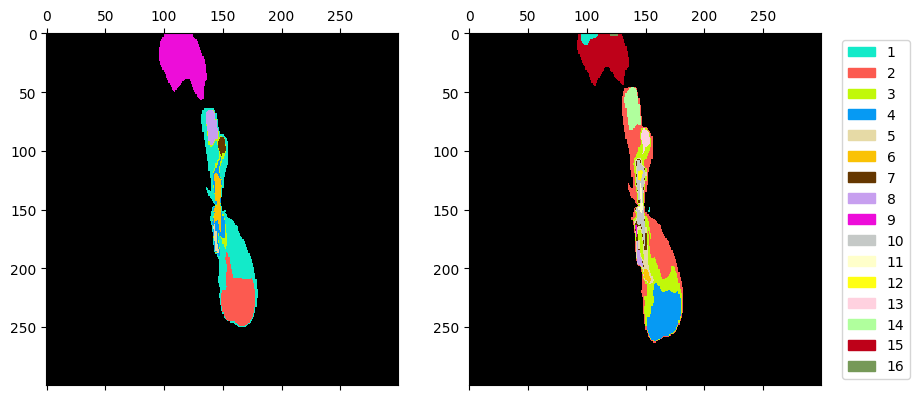

[108011.     31. 179836.  65250.  36184.   8750.    480.   3237.    911.     76.  13074.   1174.    345.   2041.  11736.  47845.    128.   1762.]
[     1.     48.  73494. 110515. 151076.  33086.  20604.  17376.    454.    864.  22551.    877.   1230.     28.    130.    496.   2665.  23710.  21797.    353.   2754.]


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,sink
0,0,437,4001,8851,32201,23720,4779,2154,2072,3951,5664,2377,1392,290,973,2124,4661,2925,1776,1090,1092,1480
1,0,0,0,0,31,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,179836,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,65250,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,36184,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,8750,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,480,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,3237,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,911,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,76,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


,1,4,7,8,9,10,12,13,14,15,16,17,18,19,20,sink
1,0,31,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,36184,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,0,0,911,0,0,0,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10,0,0,0,0,350,0,4625,0,0,1308,0,0,0,0,0,0
11,0,0,0,0,0,0,1113,0,0,0,61,0,0,0,0,0
12,0,0,0,0,345,0,0,0,0,0,0,0,0,0,0,0
13,0,0,0,0,0,0,0,0,0,0,393,1648,0,0,0,0
14,0,0,0,0,0,0,0,0,0,0,0,0,5140,0,3334,0


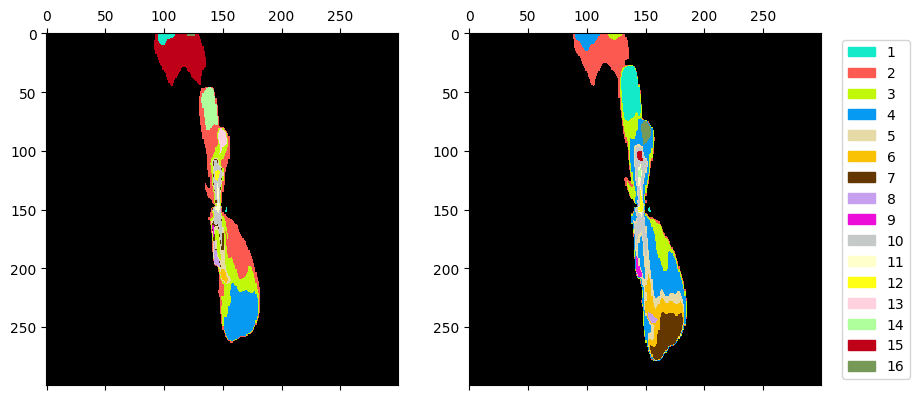

[     1.     48.  73494. 110515. 151076.  33086.  20604.  17376.    454.    864.  22551.    877.   1230.     28.    130.    496.   2665.  23710.  21797.    353.   2754.]
[     1.     23.  82892. 234458.  69598.  16452.  28656.   3212.   1235.    145.   1551.    202.    435.    864.   1598.  33609.   3644.    167.   3201.]


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,sink
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,48,0,0
2,0,0,73429,0,0,0,0,0,0,0,0,0,0,0,0,64,0,0,0,0
3,0,0,0,110503,0,0,0,0,10,0,0,0,0,0,0,0,1,0,0,0
4,0,25,0,150300,0,0,0,0,0,0,0,0,613,0,0,0,0,0,137,0
5,0,0,0,33086,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,20604,0,0,0
7,0,0,0,0,17047,0,0,0,0,0,0,0,0,296,0,0,1,0,31,0
8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,454,0
9,0,0,0,0,0,0,0,0,0,0,0,864,0,0,0,0,0,0,0,0


,1,4,6,8,9,11,12,13,14,15,17,18,sink
1,0,0,0,0,0,0,0,0,0,0,48,0,0
4,25,0,0,0,0,0,613,0,0,0,0,137,0
7,0,17047,0,0,0,0,0,296,0,0,0,31,0
8,0,0,0,0,0,0,0,0,0,0,0,454,0
9,0,0,0,0,0,864,0,0,0,0,0,0,0
10,0,0,22411,0,0,0,0,0,0,0,0,0,0
12,0,0,0,1230,0,0,0,0,0,0,0,0,0
13,0,0,0,0,0,0,0,0,0,0,0,0,0
14,0,0,0,0,130,0,0,0,0,0,0,0,0
15,0,0,0,0,0,0,0,0,0,0,0,0,0


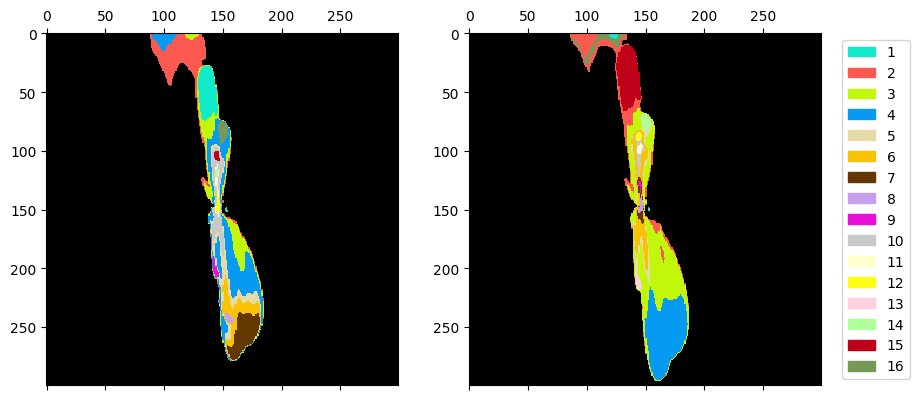

[     1.     23.  82892. 234458.  69598.  16452.  28656.   3212.   1235.    145.   1551.    202.    435.    864.   1598.  33609.   3644.    167.   3201.]
[  7993. 293042.  66837.  16734.    877.  33733.   9151.    152.   2789.   1281.    324.     69.   6241.    251.  34863.   2083.]


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,sink
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,23,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,22580,60312,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,234458,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,68652,0,0,0,0,0,0,0,0,0,0,1,0,944,0
5,0,0,0,16452,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,26922,1632,0,102,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,2577,97,538,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,599,457,179,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,145,0,0,0,0,0,0,0


,2,4,7,9,10,11,12,13,14,15,sink
1,0,0,0,0,0,0,0,0,0,0,0
4,68652,0,0,0,0,0,0,1,0,944,0
6,0,0,0,0,0,0,0,0,0,0,0
8,0,0,0,457,179,0,0,0,0,0,0
9,0,0,0,145,0,0,0,0,0,0,0
11,0,0,0,0,0,0,202,0,0,0,0
12,0,0,0,0,0,0,435,0,0,0,0
13,0,723,0,0,0,31,0,110,0,0,0
14,0,0,0,0,0,0,585,0,0,0,0
15,0,0,0,0,0,0,0,0,33464,0,0


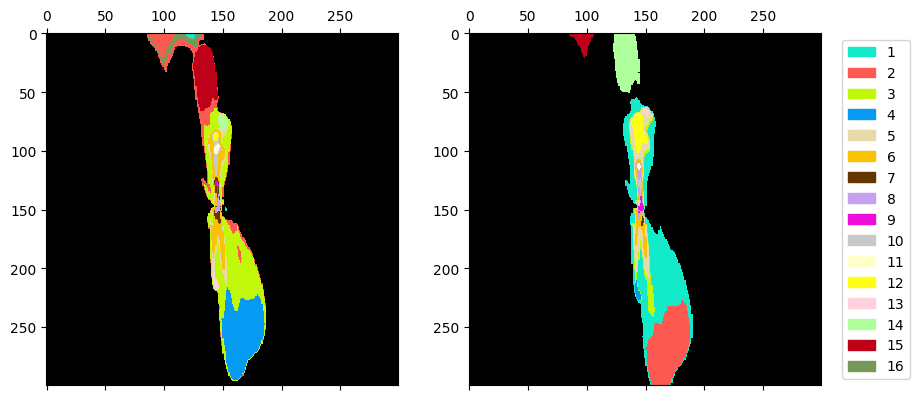

[  7993. 293042.  66837.  16734.    877.  33733.   9151.    152.   2789.   1281.    324.     69.   6241.    251.  34863.   2083.]
[     1.  12668. 313148.  11810.    103.  30009.    276.  15250.   3422.    801.  22839.  10608.    158.   4713.   8874.  10080.    189.   2994.    144.]


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,sink
0,0,411,662,526,123,411,296,700,543,487,646,522,177,405,506,524,204,404,167,279
1,0,12529,24581,18221,4339,13231,10439,28022,20225,18130,26207,19677,6372,14261,18934,19662,7320,14250,5729,10913
2,0,0,0,0,0,0,0,66837,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,16734,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,216,0,661,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,33733,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9151,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,152,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,0,2700,0,0,0,89,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,0,1281,0,0,0,0,0,0,0,0


,1,2,4,5,6,8,9,12,13,14,16,17,18,sink
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,661,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12,0,6241,0,0,0,0,0,0,0,0,0,0,0,0
13,0,251,0,0,0,0,0,0,0,0,0,0,0,0
14,34863,0,0,0,0,0,0,0,0,0,0,0,0,0
15,0,2083,0,0,0,0,0,0,0,0,0,0,0,0


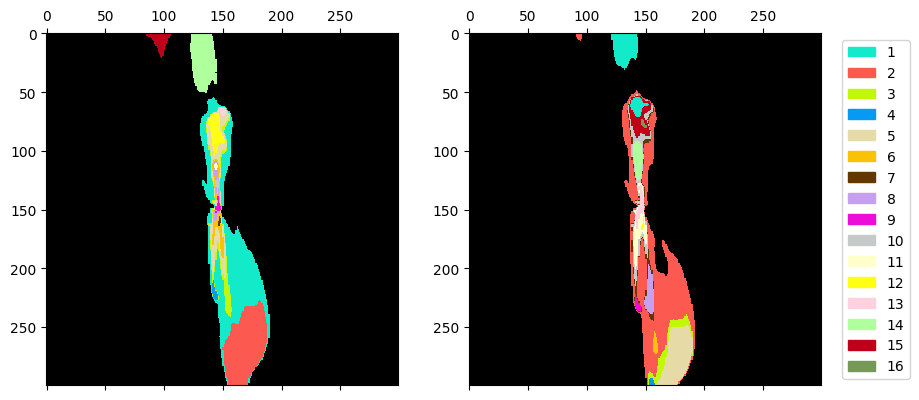

[     1.  12668. 313148.  11810.    103.  30009.    276.  15250.   3422.    801.  22839.  10608.    158.   4713.   8874.  10080.    189.   2994.    144.]
[     1. 252477.  24096.  36059.   4674.  49912.    790.     14.  28340.     26.   7420.  12252.  12819.    721.   5734.   1087.]


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,sink
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,9123,0,0,0,3518,0,0,19,0,8,0,0,0,0,0,0
2,0,313144,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0
3,0,3,10592,0,1215,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,103,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,1,29360,648,0,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,276,0,0,0,0,0,0,0,0,0,0,0,0
7,0,15250,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,0,2889,0,0,0,0,0,0,0,0,0,0,0,0,0,533,0
9,0,0,0,0,0,0,801,0,0,0,0,0,0,0,0,0,0


,3,4,6,7,9,10,11,13,14,15,sink
1,0,0,0,0,0,8,0,0,0,0,0
2,0,4,0,0,0,0,0,0,0,0,0
4,0,103,0,0,0,0,0,0,0,0,0
5,29360,648,0,0,0,0,0,0,0,0,0
6,0,276,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,533,0
9,0,0,801,0,0,0,0,0,0,0,0
12,0,0,0,11,21,0,0,0,0,0,0
13,0,0,0,0,0,4258,0,0,0,0,0
14,0,0,0,0,0,0,8874,0,0,0,0


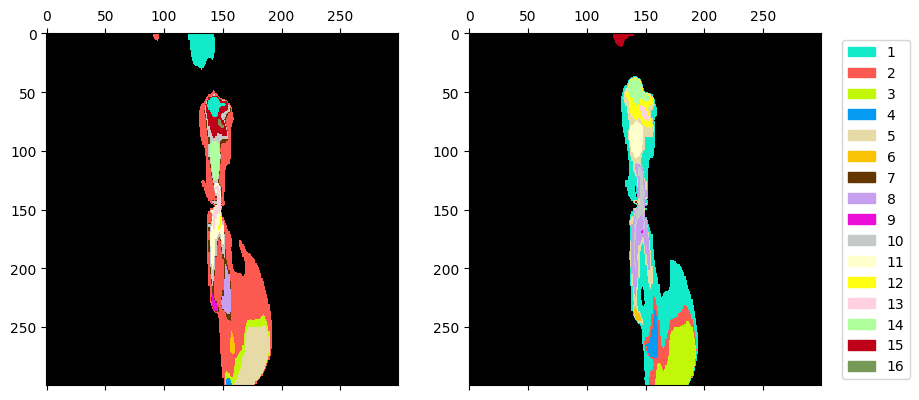

[     1. 252477.  24096.  36059.   4674.  49912.    790.     14.  28340.     26.   7420.  12252.  12819.    721.   5734.   1087.]
[212266.  18393.  31312.   3239.  27633.  20406.    772.  41596.    675.   4573.     85.   1483.   2307.    137.  40543.   6630.   3141.    506.    517.   2883.]


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,sink
0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,246129,0,0,0,6319,0,0,0,0,28,0,0,1,0,0,0,0,0,0,0,0
2,1,24089,0,0,0,0,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0
3,0,0,36038,0,0,0,0,0,0,21,0,0,0,0,0,0,0,0,0,0,0
4,0,37,0,4636,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,49911,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,301,489,0,0
7,0,0,0,0,0,0,0,0,14,0,0,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,9678,327,18334,0,1,0,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,26,0,0,0,0,0,0,0,0,0,0,0,0


,0,2,3,6,7,8,10,12,13,14,15,17,18,19,sink
3,0,36038,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,4636,0,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,0,301,489,0,0
7,0,0,0,0,0,14,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,26,0,0,0,0,0,0,0,0,0
10,0,0,0,0,3,262,55,695,74,0,0,0,0,0,0
11,0,0,0,0,0,0,0,0,0,9273,2979,0,0,0,0
13,0,0,0,0,0,0,0,0,0,0,0,0,0,721,0
14,0,0,0,0,0,0,0,0,0,0,0,0,0,897,0
15,0,0,0,0,480,0,0,0,0,0,0,0,0,0,0


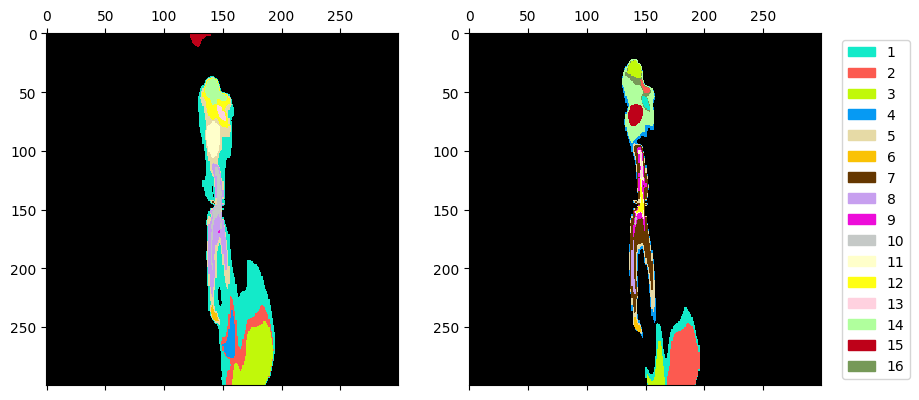

In [ ]:
import matplotlib.patches as mpatches

colornames = ["aqua", "coral", "chartreuse", "azure",
              "beige", "goldenrod", "brown", "lavender",
              "fuchsia", "silver", "ivory", "yellow",
              "light pink", "pastel green", "scarlet", "moss"
             ]
colors = [255*np.array(mplc.to_rgb("xkcd:" + c)) for c in colornames]
patches = []
for i, cname in enumerate(colornames):
    patches.append(mpatches.Patch(color="xkcd:"+cname, label=str(i+1)))
    
def color(img, branch):
    if branch.mass_frac > 0.05 and branch.id!=0:
        col = colors[(branch.id-1) % len(colors)]
        img[branch.map > 0, :] = col
        
    for c in branch.children:
        color(img, c)

for t in range(len(link_mats)):
    mat = link_mats[t]
    d = dendro_frames[t]
    d_next = dendro_frames[t+1]
    
    print_linking_matrix(mat, d, d_next)
    
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    img1 = np.zeros((*d.img.shape, 3), dtype=int)
    color(img1, d.root)
    axes[0].matshow(img1)
    
    img2 = np.zeros((*d_next.img.shape, 3), dtype=int)
    color(img2, d_next.root)
    axes[1].matshow(img2)
    
    plt.legend(handles=patches, bbox_to_anchor=(1.04,1), loc="upper left")
    plt.show()
    
    
    print('====================================')

In [ ]:
class Tracker:

    def __init__(self, dendros, link_mats):
        all_links = []
        thresh = 0.9
        for t in range(len(link_mats)):
            d, d_next = dendros[t], dendros[t+1]
            mass_mat = np.einsum('ij,i->ij', link_mats[t], d.masses)

            # bullets-only linking matrix
            mass_mat = mass_mat[:-1, :-1]
            mask = [b.mass_frac < thresh for b in d.branches]
            mass_mat[mask, :] = 0
            mask = [b.mass_frac < thresh for b in d_next.branches]
            mass_mat[:, mask] = 0

            links = set()
            for b in d.branches:
                if b.mass_frac < thresh:
                    continue
                i = b.id
                j = np.argmax(mass_mat[i, :])
                links.add((i, j, mass_mat[i, j]))
            for b in d_next.branches:
                if b.mass_frac < thresh:
                    continue
                j = b.id
                i = np.argmax(mass_mat[:, j])
                links.add((i, j, mass_mat[i, j]))
            print("{}: {}".format(t, links))
            all_links.append(links)

        trajectories = [{} for _ in dendros]
        for t, links in enumerate(all_links):
            for i, j, mass in links:
                if i not in trajectories[t]:
                    trajectories[t][i] = TrajNode(i)
                if j not in trajectories[t+1]:
                    trajectories[t+1][j] = TrajNode(j)
                inode, jnode = trajectories[t][i], trajectories[t+1][j]
                inode.next.append((jnode, mass))
                jnode.prev.append((inode, mass))

        trajectories = [node_dict.values() for node_dict in trajectories]
        for nodes in trajectories:
            for node in nodes:
                node.sort_links()

        trajcounter = 1
        thresh2 = 0.9
        for nodes in trajectories:
            for node in nodes:
                if not node.traj_id:
                    if node.prev and node.prev[0][0].contrib[node.id] > thresh2:
                        node.traj_id = node.prev[0][0].traj_id
                    else:
                        node.traj_id = trajcounter
                        trajcounter += 1
                if node.next and node.next[0][0].prev:
                    if node.next[0][0].prev[0][0] is node:
                        node.next[0][0].traj_id = node.traj_id
        
        self.frames = trajectories

        
from collections import defaultdict
class TrajNode:

    def __init__(self, id):
        self.id = id
        self.traj_id = None
        self.next = []
        self.prev = []
        self.contrib = defaultdict(float)

    def sort_links(self):
        def do_sort(nodelist):
            total = np.sum([x[1] for x in nodelist])
            nodelist = [(node, mass/total) for node, mass in nodelist]
            return sorted(nodelist, key=lambda x: x[1], reverse=True)
        self.next = do_sort(self.next)
        self.prev = do_sort(self.prev)

        for node, contrib in self.next:
            self.contrib[node.id] = contrib

tracker = Tracker(dendro_frames, link_mats)
frames = tracker.frames
for t, frame in enumerate(frames):
    print("{}: {}".format(t, [n.traj_id for n in frame]))

0: {(1, 5, 81.72472383826971), (2, 4, 53.62669765949249), (0, 0, 34111.57371723652), (1, 3, 954.2959427237511), (0, 1, 190.51235694251955), (1, 6, 55.3985040076077)}
1: {(0, 0, 60775.62782013416), (4, 6, 20.13357639312744), (5, 7, 10.431900948286057), (4, 5, 99.86181020736694), (6, 8, 112.55983126163483), (3, 5, 295.24481946229935), (0, 1, 291.3572278171778), (5, 5, 118.99644827842712), (1, 4, 262.15731543302536), (5, 9, 2.5673207715153694)}
2: {(9, 11, 0.0018330680140934419), (1, 1, 405.62423038482666), (0, 5, 134.46130425157025), (5, 8, 543.4833550453186), (4, 4, 388.0), (0, 11, 475.1932507380843), (8, 10, 135.9643406867981), (0, 0, 89554.37315964699), (7, 8, 11.996315717697144), (6, 7, 24.0)}
3: {(0, 0, 120679.95070695877), (7, 5, 23.99773406982422), (11, 9, 769.0), (0, 7, 0.00014034613244229277), (8, 4, 0.051841111460817046), (4, 2, 410.20782405138016), (10, 10, 372.0), (1, 2, 259.99704003334045), (5, 2, 203.59127569198608), (8, 5, 1177.9113193750381)}
4: {(4, 7, 64.58778202533722)

In [ ]:
colornames2 = ["brown", "coral", "chartreuse", "azure",
              "beige", "goldenrod", "aqua", "lavender",
              "fuchsia", "silver", "ivory", "yellow",
              "light pink", "pastel green", "scarlet", "moss"
             ]
colors2 = [255*np.array(mplc.to_rgb("xkcd:" + c)) for c in colornames2]

imgs = []
for t in range(2, 16):

    img = np.zeros((*d.img.shape, 3), dtype=np.uint8)
    
    for node in frames[t]:
        branch = dendro_frames[t].branches[node.id]
        traj_id = node.traj_id
        if branch.mass_frac > 0.8 and branch.id!=0:
            col = colors2[traj_id % len(colors2)]
            intensity = branch.map/branch.map.max()
            img += np.einsum('ij,k->ijk', intensity, col).astype(np.uint8)
    
    # cv2.imwrite("{:02}.png".format(t), img)
    imgs.append(img)

# imageio.mimsave('trajec.gif', imgs, fps = 5)

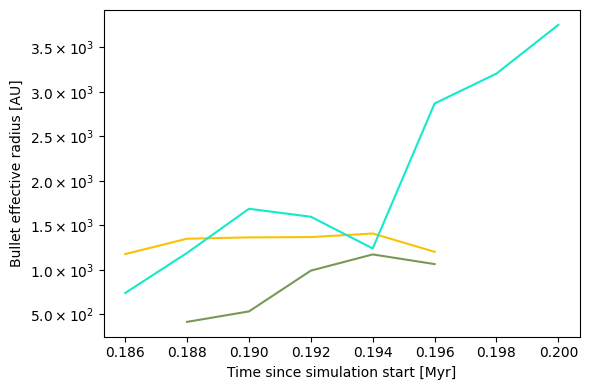

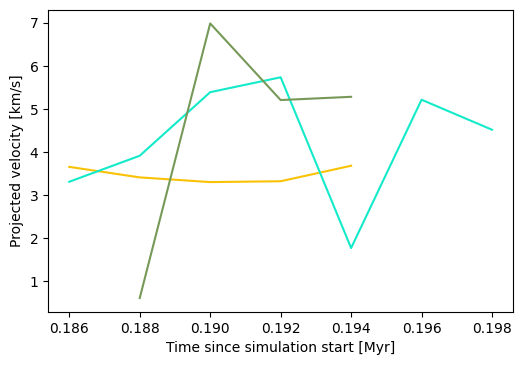

In [ ]:
from collections import defaultdict
import matplotlib.ticker as mtick

def as_si(x, pos):
    s = '{x:0.1e}'.format(x=x)
    m, e = s.split('e')
    return r'${m:s}\times 10^{{{e:d}}}$'.format(m=m, e=int(e))

with open("times.txt") as f:
    lines = f.readlines()
    lines = [float(l.split()[1]) for l in lines][::3]
    times = np.round(lines, 6)
times = np.round(lines, 3)

traj_data = defaultdict(list)
for t in range(4, 12):
    for node in frames[t]:
        if node.id == 0:
            continue
        if node.traj_id == 15 and t>9:
            continue
        if node.traj_id == 1:
            continue
        branch = dendro_frames[t].branches[node.id]
        traj_id = node.traj_id
        px_to_au = 53476.69696 / branch.map.shape[0]
        px_to_km = 8e12 / branch.map.shape[0]
        Myr_to_s = 3.15576e13
        r_eff = px_to_au * np.sqrt(np.sum(branch.map > 0) / np.pi)
        dt = Myr_to_s*(times[t+1] - times[t])
        dx = 0
        for n,_ in node.next:
            if n.traj_id == traj_id:
                b_next = dendro_frames[t+1].branches[n.id]
                dx = px_to_km * np.linalg.norm(b_next.x - branch.x)
        traj_data[traj_id].append((times[t], r_eff, dx/dt))

for traj_id, data in traj_data.items():
    t, r_effs, _ = np.transpose(data)
    col = colors2[traj_id % len(colors2)] / 255
    if len(t) > 3:
        plt.plot(t, r_effs, color=col)

plt.xlabel('Time since simulation start [Myr]')
plt.ylabel('Bullet effective radius [AU]')
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(as_si))
plt.tight_layout()
plt.savefig('effective_rad.png', dpi=300)
plt.show()

for traj_id, data in traj_data.items():
    t, _, v = np.transpose(data)
    col = colors2[traj_id % len(colors2)] / 255
    if len(t) > 3:
        plt.plot(t[:-1], v[:-1], color=col)

plt.xlabel('Time since simulation start [Myr]')
plt.ylabel('Projected velocity [km/s]')
plt.savefig('velocity.png', dpi=300)
plt.show()

In [ ]:
%matplotlib inline
import ipywidgets as widgets
plt.rcParams["figure.figsize"] = (8,8)

def animate_traj(track_frames, traj):
    empty = 0*track_frames[0].nodes[0].map
    
    @widgets.interact(iter=(0, 20, 1))
    def make_plot(iter):
        branch = traj[iter]
        map = branch.map if branch is not None else empty
        plt.matshow(map, vmin=0, vmax=100)
        plt.colorbar()
        plt.gca().set_aspect('equal')
        plt.show()

animate_traj(track_frames, traj)

interactive(children=(IntSlider(value=10, description='iter', max=20), Output()), _dom_classes=('widget-intera…

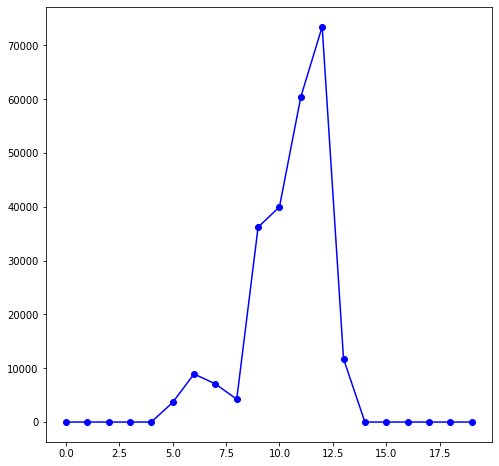

In [ ]:
masses = [b.mass if b is not None else 0 for b in traj]
plt.plot(masses, 'bo-')

In [ ]:
print(masses)

[0, 0, 0, 0, 0, 3638.0, 8935.0, 7089.0, 4237.0, 36215.0, 39992.0, 60426.0, 73485.0, 11736.0, 0, 0, 0, 0, 0, 0]
